In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity
import os
import time

In [2]:
# Load dataset
df = pd.read_csv("train.csv")

# Tampilkan informasi dasar
print("Jumlah baris:", len(df))
print("Jumlah user unik:", df['user_id'].nunique())
print("Jumlah item unik:", df['item_id'].nunique())
df.head()

Jumlah baris: 269764
Jumlah user unik: 13876
Jumlah item unik: 123069


,user_id,item_id
0,8,0002005018
1,8,074322678X
2,8,0887841740
3,8,1552041778
4,8,1567407781


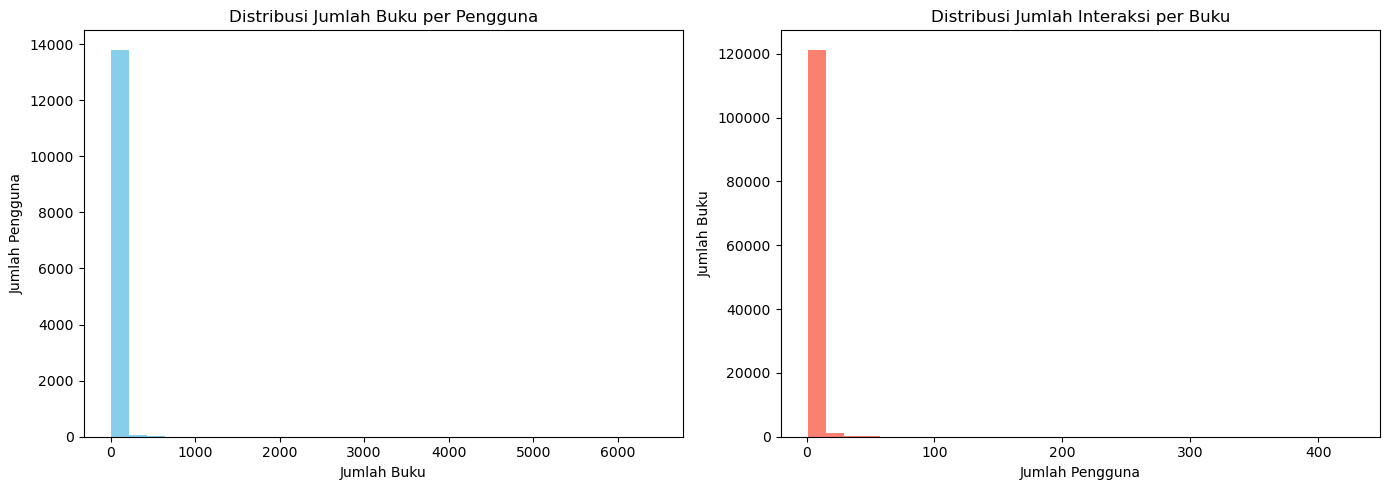

In [3]:
# Jumlah interaksi per user
user_interactions = df['user_id'].value_counts()

# Jumlah interaksi per item
item_interactions = df['item_id'].value_counts()

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Distribusi interaksi per user
ax[0].hist(user_interactions, bins=30, color='skyblue')
ax[0].set_title("Distribusi Jumlah Buku per Pengguna")
ax[0].set_xlabel("Jumlah Buku")
ax[0].set_ylabel("Jumlah Pengguna")

# Distribusi popularitas item
ax[1].hist(item_interactions, bins=30, color='salmon')
ax[1].set_title("Distribusi Jumlah Interaksi per Buku")
ax[1].set_xlabel("Jumlah Pengguna")
ax[1].set_ylabel("Jumlah Buku")

plt.tight_layout()
plt.show()


In [4]:
# Hitung jumlah interaksi per item
item_popularity = df['item_id'].value_counts().reset_index()
item_popularity.columns = ['item_id', 'popularity']

# Rekomendasikan 10 item teratas untuk setiap user
top_10_items = item_popularity['item_id'].head(10).tolist()

# Buat dictionary rekomendasi
pop_recommendations = {user: top_10_items for user in df['user_id'].unique()}

print("10 item paling populer:", top_10_items)


10 item paling populer: ['0316666343', '0385504209', '0312195516', '0142001740', '059035342X', '0060928336', '0446672211', '0345337662', '0452282152', '0316601950']


In [5]:
# Pilih subset pengguna & item (untuk efisiensi memori)
top_users = df['user_id'].value_counts().head(2000).index
top_items = df['item_id'].value_counts().head(4000).index

df_small = df[df['user_id'].isin(top_users) & df['item_id'].isin(top_items)]

print(f"Subset data: {df_small['user_id'].nunique()} users × {df_small['item_id'].nunique()} items")


Subset data: 1923 users × 3999 items


In [6]:
# ===== Buat matriks user-item =====
user_item_matrix = pd.crosstab(df_small['user_id'], df_small['item_id'])

# ===== Hitung similarity antar item =====
item_similarity = pd.DataFrame(
    cosine_similarity(user_item_matrix.T),
    index=user_item_matrix.columns,
    columns=user_item_matrix.columns
)

# ===== Fungsi rekomendasi =====
def recommend_ibcf(user_id, n=10):
    if user_id not in user_item_matrix.index:
        return []
    interacted_items = user_item_matrix.loc[user_id]
    interacted_items = interacted_items[interacted_items > 0].index.tolist()

    scores = {}
    for item in interacted_items:
        similar_items = item_similarity[item].sort_values(ascending=False)
        for sim_item, score in similar_items.items():
            if sim_item not in interacted_items:
                scores[sim_item] = scores.get(sim_item, 0) + score

    ranked_items = sorted(scores.items(), key=lambda x: x[1], reverse=True)
    return [x[0] for x in ranked_items[:n]]

In [7]:
# Pilih 5 pengguna acak dari subset
sample_users = np.random.choice(user_item_matrix.index, 5, replace=False)

for u in sample_users:
    recs = recommend_ibcf(u, n=10)
    print(f"\nTop 10 Rekomendasi untuk User {u}:")
    for i, r in enumerate(recs, start=1):
        print(f"{i}. {r}")


Top 10 Rekomendasi untuk User 224525:
1. 0871136791
2. 0140280553
3. 0517703963
4. 0446615145
5. 0345381432
6. 0345305183
7. 044022859X
8. 0399135782
9. 0684196395
10. 0156907399

Top 10 Rekomendasi untuk User 88229:
1. 034543739X
2. 0375727345
3. 051513290X
4. 0060540753
5. 0345443128
6. 0553569619
7. 0375726403
8. 0425162443
9. 0312195516
10. 0670894605

Top 10 Rekomendasi untuk User 229329:
1. 0517703963
2. 0446615145
3. 0345381432
4. 0312202318
5. 0446606251
6. 0887307876
7. 155874262X
8. 1558744150
9. 0312971230
10. 0449910830

Top 10 Rekomendasi untuk User 115003:
1. 0517703963
2. 0446615145
3. 0345381432
4. 038081093X
5. 0156907399
6. 0446606251
7. 0345443128
8. 0887307876
9. 0060540753
10. 0312202318

Top 10 Rekomendasi untuk User 51883:
1. 0517703963
2. 0345381432
3. 0446615145
4. 0440205573
5. 0440173701
6. 0440224810
7. 0446606251
8. 0440200563
9. 0440176484
10. 0385306024


In [8]:
from sklearn.model_selection import train_test_split
from tqdm import tqdm

train_df, test_df = train_test_split(df_small, test_size=0.2, random_state=42)

train_matrix = pd.crosstab(train_df['user_id'], train_df['item_id'])
test_matrix = pd.crosstab(test_df['user_id'], test_df['item_id'])

item_similarity_train = pd.DataFrame(
    cosine_similarity(train_matrix.T),
    index=train_matrix.columns,
    columns=train_matrix.columns
)

def recommend_from_train(user_id, n=10):
    if user_id not in train_matrix.index:
        return []
    interacted_items = train_matrix.loc[user_id]
    interacted_items = interacted_items[interacted_items > 0].index.tolist()

    scores = {}
    for item in interacted_items:
        similar_items = item_similarity_train[item].sort_values(ascending=False)
        for sim_item, score in similar_items.items():
            if sim_item not in interacted_items:
                scores[sim_item] = scores.get(sim_item, 0) + score

    ranked_items = sorted(scores.items(), key=lambda x: x[1], reverse=True)
    return [x[0] for x in ranked_items[:n]]

# MAP@10
def apk(actual, predicted, k=10):
    if len(predicted) > k:
        predicted = predicted[:k]
    score, num_hits = 0.0, 0.0
    for i, p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i + 1.0)
    return score / min(len(actual), k) if actual else 0.0

def mapk(actual_list, predicted_list, k=10):
    return np.mean([apk(a, p, k) for a, p in zip(actual_list, predicted_list)])

# Evaluasi
actual, predicted = [], []
for user in tqdm(test_matrix.index):
    actual_items = test_matrix.loc[user]
    actual_items = actual_items[actual_items > 0].index.tolist()
    pred_items = recommend_from_train(user, n=10)
    actual.append(actual_items)
    predicted.append(pred_items)

map10 = mapk(actual, predicted, k=10)
print(f"\n🎯 MAP@10 pada subset data: {map10:.4f}")


100%|██████████████████████████████████████████████████████████████████████████████| 1716/1716 [07:29<00:00,  3.82it/s]


🎯 MAP@10 pada subset data: 0.0303
